# Demo RNA usando Auto-Keras para identificar clases

Fuente:https://autokeras.com/

0) Preparar el ambiente

In [1]:
#@title Instalar Auto-Keras 
#!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install keras-tuner --upgrade
!pip install autokeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 28.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 17.3 MB/s 


1) Cargar librerías:

In [2]:
#@title Librerías a usar
import autokeras as ak

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
import csv

print("Librerías cargadas")

Librerías cargadas


2) Cargar los datos:

In [3]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [23]:
## selección de los parámetros 

def cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return atributo_clase, nombre_clases

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = '-' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = '-' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   70#@param {type:"integer"}

## aplicación de los parámetros elegidos

if atributo_clase == '' or  atributo_clase == '-':
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases)


# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

# define valores de clases para ejemplo IRIS
CLASES = [ ]
for val in nombre_clases.split(','):
  CLASES.append( val )

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)
print("Atributo clase: ", ClassAttributeName, ": ", CLASES)


> Definición de los valores discretos para la clase cargada de IRIS_nombreClases.txt.

Configuración definida de  IRIS.csv
Atributo clase:  Clase :  ['na', 'Setosa', 'Versicolor', 'Virginica']


In [24]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())

# genera los datos solo con la clase para entrenar y probar
Y = df.pop(ClassAttributeName)
X = df

# convierte a numpy para tener compatibilidad con AutoKeras
X = X.to_numpy()
Y = Y.to_numpy()

#X = X.astype(np.unicode)
#Y = Y.astype(np.unicode)



> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max       7.900000     4.400000     6.9

In [25]:
#@title Preparar datos

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)

# genera salida codificada para softMax
y_trainEnc =  to_categorical(y_train)
y_testEnc =  to_categorical(y_test)

# muestra resultados
print("> Para Ambos: ")
print(" - dictMapeo: ", CLASES)

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
for i in range(len(CLASES)):
  cant = 0
  for y in y_train:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
for i in range(len(CLASES)):
  cant = 0
  for y in y_test:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)


> Para Ambos: 
 - dictMapeo:  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (104, 4)
 - y_train (cant):  104
     na [ 0 ]: 0
     Setosa [ 1 ]: 35
     Versicolor [ 2 ]: 35
     Virginica [ 3 ]: 34

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (46, 4)
 - y_test (cant):  46
     na [ 0 ]: 0
     Setosa [ 1 ]: 15
     Versicolor [ 2 ]: 15
     Virginica [ 3 ]: 16


3) Establecer el modelo para la RNA

In [26]:
#@title Establecer modelo base para AutoKeras

cantidad_intentos_encontrar_modelo = 5 #@param {type:"integer"}
if cantidad_intentos_encontrar_modelo < 1:
  cantidad_intentos_encontrar_modelo = 1

max_epocas_entrenamiento =  300#@param {type:"integer"}
if max_epocas_entrenamiento <= 0:
  max_epocas_entrenamiento = None

# AutoKeras siempre se usa salida softmax 
# (se puede usar salida lineal pero lo aplica el pipeline,
#  no el modelo que se exporta)
tipo_output_softMax = True

AKmodel = ak.StructuredDataClassifier(num_classes=len(CLASES), 
                                      overwrite=True, 
                                      seed=1,
                                      max_trials=cantidad_intentos_encontrar_modelo)

print("Modelo preparado")

Modelo preparado


4) Entrenar el modelo de la RNA:

In [27]:
#@title Entrenar con AutoKeras

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

# el history sólo devuelve el del último trial
#history = 
AKmodel.fit(x_t, y_t,
                      validation_data=(x_v, y_v,),
                      epochs=max_epocas_entrenamiento
                      )

print("\n>Entrenamiento Finalizado.")


Trial 5 Complete [00h 00m 08s]
val_accuracy: 0.9090909361839294

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 47s
INFO:tensorflow:Oracle triggered exit
Epoch 1/300
3/3 [==============================] - 1s 107ms/step - loss: 1.5326 - accuracy: 0.0323 - val_loss: 1.4740 - val_accuracy: 0.0909
Epoch 2/300
3/3 [==============================] - 0s 19ms/step - loss: 1.4706 - accuracy: 0.1183 - val_loss: 1.4056 - val_accuracy: 0.1818
Epoch 3/300
3/3 [==============================] - 0s 18ms/step - loss: 1.4125 - accuracy: 0.2688 - val_loss: 1.3431 - val_accuracy: 0.4545
Epoch 4/300
3/3 [==============================] - 0s 19ms/step - loss: 1.3579 - accuracy: 0.4301 - val_loss: 1.2841 - val_accuracy: 0.9091
Epoch 5/300
3/3 [==============================] - 0s 18ms/step - loss: 1.3060 - accuracy: 0.6989 - val_loss: 1.2291 - val_accuracy: 0.9091
Epoch 6/300
3/3 [==============================] - 0s 19ms/step - loss: 1.2565 - accuracy: 0.7849 - val_loss: 1.1758 - val_accuracy: 1

In [28]:
 #@title Mostrar Resumen de las Pruebas realizadas por AutoKeras
 print(AKmodel.tuner.results_summary())

resEval = AKmodel.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Mejor Modelo con datos de Prueba: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

Results summary
Results in ./structured_data_classifier
Showing 10 best trials
Trial summary
Hyperparameters:
structured_data_block_1/normalize: True
structured_data_block_1/dense_block_1/use_batchnorm: False
structured_data_block_1/dense_block_1/num_layers: 2
structured_data_block_1/dense_block_1/units_0: 32
structured_data_block_1/dense_block_1/dropout: 0.0
structured_data_block_1/dense_block_1/units_1: 32
classification_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
Score: 1.0
Trial summary
Hyperparameters:
structured_data_block_1/normalize: True
structured_data_block_1/dense_block_1/use_batchnorm: False
structured_data_block_1/dense_block_1/num_layers: 2
structured_data_block_1/dense_block_1/units_0: 32
structured_data_block_1/dense_block_1/dropout: 0.0
structured_data_block_1/dense_block_1/units_1: 32
classification_head_1/dropout: 0.0
optimizer: adam_weight_decay
learning_rate: 0.001
Score: 1.0
Trial summary
Hyperparameters:
structured_data_block_1/normalize: True
struc

In [29]:
#@title Exportar Modelo y Re-Entrenar (opcional)

reentrenar_modelo = False #@param {type:"boolean"}

cant_epocas_reentrenamiento =  500#@param {type:"integer"}
if cant_epocas_reentrenamiento <= 0:
  cant_epocas_reentrenamiento = None


# exporta el modelo y lo muestra
print("\n>> Mejor modelo generado: ")
model = AKmodel.export_model()
model.summary()
print("")

if reentrenar_modelo: 
  # realiza el re-entrenamiento del modelo
  print("\n\n>Comienza el Re-Entrenamiento:")
  history = model.fit(x_t, y_t,
                        validation_data=(x_v, y_v,),
                        epochs=cant_epocas_reentrenamiento
                        )
  print("\n>Re-Entrenamiento Finalizado.")


>> Mejor modelo generado: 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 4)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                160       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (Non

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        35
  Versicolor       1.00      0.97      0.99        35
   Virginica       0.97      1.00      0.99        34

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104


Matriz de Confusión ( real / modelo ): 
              m:na  m:Setosa  m:Versicolor  m:Virginica
r:na             0         0             0            0
r:Setosa         0        35             0            0
r:Versicolor     0         0            34            1
r:Virginica      0         0             0           34




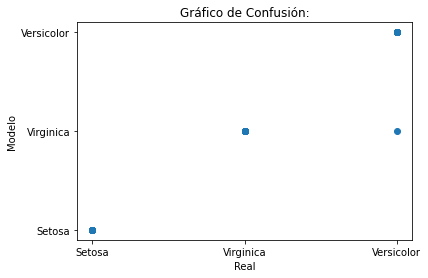

In [30]:
#@title Probar red entrenada con datos de entrenamiento
mostrar_detalle_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, clases_map, mostrarDetalle=False):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = int(predClass[i][0])       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:      
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / Modelo(RNA): ' 
        strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'   
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    print(cmtx)
    print("\n")

    # gráfico de comparación
    plt.title('Gráfico de Confusión:')
    plt.xlabel('Real')
    plt.ylabel('Modelo')
    plt.scatter(classReal, classPreds)

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, CLASES, mostrar_detalle_entrenamiento)


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:

2/2 [==============================] - 0s 7ms/step - loss: 0.1336 - accuracy: 0.9348

>Evaluación del Modelo: 
    - Error:  0.13360042870044708
    - Exactitud:  93.478262424469




*** Resultados con datos de Prueba: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        15
  Versicolor       0.93      0.87      0.90        15
   Virginica       0.88      0.94      0.91        16

    accuracy                           0.93        46
   macro avg       0.94      0.93      0.94        46
weighted avg       0.94      0.93      0.93        46


Matriz de Confusión ( real / modelo ): 
              m:na  m:Setosa  m:Versicolor  m:Virginica
r:na             0         0             0            0
r:Setosa         0        15             0            0
r:Versicolor     0         0            13            2
r:Virginica      0         0             1           15




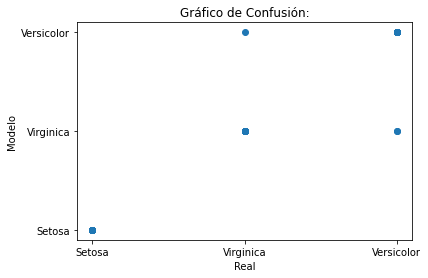

In [31]:
#@title Probar red entrenada con datos de prueba
mostrar_detalle_prueba = False #@param {type:"boolean"}
 
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, CLASES, mostrar_detalle_prueba)